<a href="https://colab.research.google.com/github/thad75/TP_ENSEA_ELEVE/blob/main/2A/Option%20IA/TP3/Creating_a_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown
!gdown --id 1b9XN-AD2ph6Akdy4gpWdx8rIlK6HZ-u9
!pip install pytorch-lightning
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import pytorch_lightning as pl
import numpy as np
from scipy.sparse.csgraph import laplacian
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
import scipy.sparse as sparse
from sklearn import preprocessing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn import preprocessing
import torch

from sklearn.model_selection import train_test_split

     |████████████████████████████████| 78 kB 4.3 MB/s eta 0:00:01
You should consider upgrading via the '/Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/recoSysPractice/virtualenv/bin/python3 -m pip install --upgrade pip' command.
/Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/recoSysPractice/virtualenv/lib/python3.9/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1b9XN-AD2ph6Akdy4gpWdx8rIlK6HZ-u9
To: /Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/recoSysPractice/ratings_Beauty.csv
100%|██████████████████████████████████████| 82.4M/82.4M [00:05<00:00, 15.8MB/s]
     |████████████████████████████████| 815 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 37.4 MB/s eta 0:00:01
     |████████████████████████████████| 62.1 MB 424 kB/s  eta 0:00:01     |

Before beginning anything :    
* Go on the following link : https://drive.google.com/drive/folders/11jRhJ9febEg7eQ8aGx0x0P8iqLpVwCNS?usp=sharing
* Read the README file

# Recommendation Systems

A Recommendation System is a system able to recommend an item for a user depending on either :
* the content watched by the user i.e content based filtering
* the behavior of a user on items i.e collaborative filtering

In this lab, we will see two different Recommendation System Algorithm.

# Goal of this lab

* Understand Recommendation Systems
* Build a Graph Recommendation System
* Build a Matrix Factorisation Recommendation System
* Use Pytorch Lightning
* Understand the importance of Embeddings in Deep Learning

# I - Dataset

For this lab, we will be using a famous dataset. We will use the Amazon Luxury Dataset. The data are loaded into a Pandas Dataframe. Let's analyze and understand the dataset.



* What are the Dataframes keys ?
* How many items are there ? How many users are there ?
* What's the span of the ratings ?
* Plot the number of Ratings that are present. Is it a Gaussian Distribution ? A Skewed Gaussian Distribution ?
* What could it mean on the quality of the products ?


## Applying it on a real Dataset


* Using pivot methods, transform your dataframe to a Rating Matrix. If your session crashes, pass this question. You'll create other Rating Matrix later.

In [2]:
# TODO : Read the downloaded CSV file
df = pd.read_csv('./ratings_Beauty.csv')
# TODO : Answer the previous questions


In [3]:
# let's make a little data exploration

# first thing first
df.head()

# the data set is simple and straight forward, we have, for each row, a user-item pair with the associated rating (0, 5, step=1)
# and the timestamp of the rating
print('dataset keys:', df.keys())
print('number of datapoint:', df.shape[0])
min, max = df['Rating'].min(), df['Rating'].max()
print('span of the ratings:', f'from {min} to {max}')


dataset keys: Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')
number of datapoint: 2023070
span of the ratings: from 1.0 to 5.0


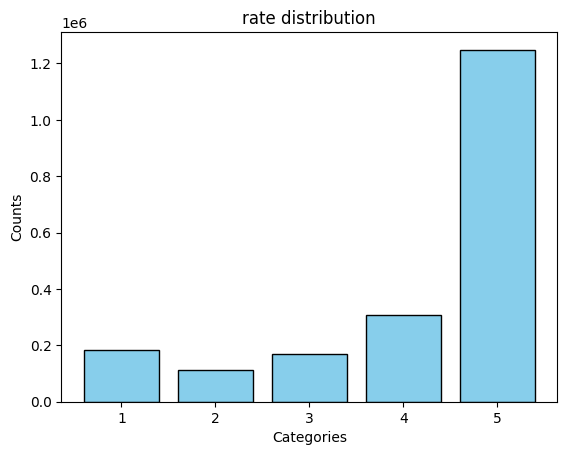

In [4]:
# let plot ratings distribution
import matplotlib.pyplot as plt

# Example data
data = df['Rating']
counts = [data.value_counts()[float(i + 1)] for i in range(5)]
# Plot histogram
plt.bar([1, 2, 3, 4, 5], counts, color='skyblue', edgecolor='black')
plt.xticks([1, 2, 3, 4, 5])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('rate distribution')

plt.show()

In [5]:
# we can clearly see a left skewed gaussian distribution wich tell us intuitively
# that majority of users rated highly (4 / 5)
freq = ( (data.value_counts()[float(4)] + data.value_counts()[float(5)]) / data.shape[0] ) * 100

print(f'--> 4 and 5 ratings proportion: {freq:.3f} %')

--> 4 and 5 ratings proportion: 76.936 %


In [6]:
# we can confidently say that the overall quality of the products are good as more than 75% of the product are posively rated.

# II - Matrix Factorization


## The Theory

Matrix Factorization is an easy yet powerful recommendation algorithm. In fact, it is a simple embedding model. To remind you, an embedding is another representation of a vector, in a lower dimension space. The good thing about Matrix Factorization is its usability for either content based recommendation or collaborative filtering based recommendation. This is one of the earliest model used by Netflix.

Matrix Factorization finds latent structure in data such as it decomposes a Feedback Matrix $A\in \mathbb{R}^{M*N}$ with M the number of users and n the number of items, into :     
* $P$ :  a user embedding matrix $\in \mathbb{R}^{M*K}$
* $Q$ : an item embedding matrix $\in \mathbb{R}^{N*K}$

The embeddings are learned such that
$ \hat{A} = P*Q^{T} \approx A$

We define the Objective Function as

$ \underset{P \in \mathbb{R}^{M*K},  Q\in \mathbb{R}^{N*K}} min\underset{i,j\in{obs}}\sum(A_{ij} - \hat{A{ij}})^{2} $ over $P$ and  $Q$

To update the values of the matrixes, we use the typical Gradient Descent. In fact, each element of P and Q are updated using the following equations :

$p_{ik} = p_{ik} + 2\alpha*error* q_{kj}$

$q_{kj} = q_{kj} + 2\alpha*error* p_{ik}$



* Where do the $p_{ik}$ and $q_{kj}$ update formula come from ?

--> the formula come from the derivative of the loss function with respect to each 'weight' or entries of the matrix. multiplied by \alpha the learning rate

for the detail:
the factor 2 is the square going down
then we use the chain rule to pull out Aij wich leave the error intact
then we derivate Aij with respect to P or Q wich leave respectively P or Q


Now, we are going to code the Matrix Factorization Class that will perform matrix factorization for us.

The class has 4 methods :
* the init : for attribute initialization
* the error : to compute the error
* the update : to update the elements of P and Q
* the run : to perform the calcultation for a num_step of times

In [7]:
user_latent = np.array([[1, 1, 2, 5, 5],
                        [2, 2, 5, 5, 5],
                       [3, 3, 3, 4, 4] ])

item_latent = np.array([[1, 1, 2],
                        [2, 2, 5],
                        [3, 5, 3],
                        [3, 6, 3],
                        [3, 7, 3]])

print(user_latent.shape, item_latent.shape)

print(user_latent[:, 2])

(3, 5) (5, 3)
[2 5 3]


In [8]:
class Matrix_Factorization():
  """
  This class performs Matrix Factorization for a given FeedBack Matrix


  """

  def __init__(self,A, latent_dim, steps= 5000, learning_rate = 0.0002):

      self.A = A
      self.latent_dim = latent_dim
      self.steps = steps
      self.learning_rate = learning_rate

      # TODO : Initialize the correct attributes
      # M,N are the shape of the FeedBack Matrix
      self.M, self.N  = A.shape[0], A.shape[1]

      # TODO : Initialize two random matrix P and Q. Don't forget to Transpose Q
      self.P = np.random.rand(self.M, self.latent_dim)
      self.Q = ( np.random.rand(self.N, self.latent_dim) ).transpose()

  def error(self, a, b):
      # TODO : Return the error : the difference between a and b
      return (a - b)

  def update(self):
    # TODO : Perform element update using gradient descent
    # TODO : Iterate among the user
    for user in range(self.M):
        # TODO : Iterate among the items
        for item in range(self.N):
          if self.A[user][item]> 0: # why ??
            # TODO : Compute the error between the GT Rating and the Predicted Rating of user on item
            error = self.error(self.A[user][item], np.dot(self.P, self.Q)[user][item])
            # TODO : Using the gradient descent formula update the values of the elements of P and Q
            for latent in range(self.latent_dim):
                self.P[user][latent] = self.P[user][latent] + 2 * self.learning_rate * error * self.Q[latent][item]
                self.Q[latent][item] = self.Q[latent][item] + 2 * self.learning_rate * error * self.P[user][latent]


  def run(self):
    # TODO : Call the update method 'steps' times
    for step in range(self.steps) :
        self.update()
        mat = np.dot(self.P, self.Q)
    return mat


### Testing it on Collaborative Filtering

We give you this R matrix. As you can see the R matrix contains some outliers (Nan values)
* How can we handle the outliers in this R matrix, what changes should you do ?
* Define a function that handles the outliers of your input matrix.

In [9]:
# Not TODO : Define a Rating Matrix. An example of Rating Matrix is given
R = np.array([[np.NaN,5,1,0,4],
              [0,0,1,0,3],
              [0,5,0,2,np.NaN],
              [1,np.NaN,0,5,1] ])

# TODO : Define a function that handles the outliers of the R matrix. Hint nan_to_num
def correct_outliers(R):
    return np.nan_to_num(R, nan=0)

# TODO : Verify that your function works
R = correct_outliers(R)
R

array([[0., 5., 1., 0., 4.],
       [0., 0., 1., 0., 3.],
       [0., 5., 0., 2., 0.],
       [1., 0., 0., 5., 1.]])

In [10]:
# TODO : Create an instance of the Matrix_Factorization Class
latent_dim = 2
MF = Matrix_Factorization(A = R,
                          latent_dim=latent_dim)

In [11]:
# TODO : Calculate the approximated Rating Matrix using the run method
mat = MF.run()

In [12]:
print(mat)

[[1.97273091 5.15930371 1.07663263 5.91140513 3.67225872]
 [1.65646176 4.34146553 0.91656429 4.89319505 3.09324331]
 [1.7204276  4.91011896 1.49235389 2.04393032 3.63175575]
 [0.88115573 2.00525429 0.07763717 4.90765052 1.32756175]]


## Testing on the Luxury Dataset

Now let's test our model on the Luxury Dataset. As you've seen, there's too much data for this Algorithm to handle. The computation time would be too much. We are going to restrict the dataset for the 50 first elements.
In order to check the capacity of the algorithm. We masked few ratings to Nan values. The goal is to check if the model would be able to recapture the original rating.

In [13]:
# TODO : Keep the 50 first elements of the df dataframe
mf_df = df.iloc[:50]

mf_df_train = mf_df.copy()

print(mf_df)

            UserId   ProductId  Rating   Timestamp
0   A39HTATAQ9V7YF  0205616461     5.0  1369699200
1   A3JM6GV9MNOF9X  0558925278     3.0  1355443200
2   A1Z513UWSAAO0F  0558925278     5.0  1404691200
3   A1WMRR494NWEWV  0733001998     4.0  1382572800
4   A3IAAVS479H7M7  0737104473     1.0  1274227200
5    AKJHHD5VEH7VG  0762451459     5.0  1404518400
6   A1BG8QW55XHN6U  1304139212     5.0  1371945600
7   A22VW0P4VZHDE3  1304139220     5.0  1373068800
8   A3V3RE4132GKRO  130414089X     5.0  1401840000
9   A327B0I7CYTEJC  130414643X     4.0  1389052800
10  A1BG8QW55XHN6U  130414643X     5.0  1372032000
11   AIFAAVTUYHEHB  130414643X     4.0  1378252800
12   AVOGV98AYOFG2  1304146537     5.0  1372118400
13  A22VW0P4VZHDE3  130414674X     5.0  1371686400
14   AVOGV98AYOFG2  1304168522     5.0  1372118400
15   A6R426V4J7AOM  1304168522     5.0  1373414400
16  A22VW0P4VZHDE3  1304174778     5.0  1372896000
17   AKGB62WGF35J8  1304174778     5.0  1372896000
18  A22VW0P4VZHDE3  1304174867 

In [14]:
# Here we apply some Random Nan values
random.seed(10)
for i,value in enumerate(mf_df_train['Rating']):
  if random.randint(0,5)==5:
      mf_df_train.loc[i, 'Rating'] = np.NaN
print(mf_df_train)

            UserId   ProductId  Rating   Timestamp
0   A39HTATAQ9V7YF  0205616461     5.0  1369699200
1   A3JM6GV9MNOF9X  0558925278     3.0  1355443200
2   A1Z513UWSAAO0F  0558925278     5.0  1404691200
3   A1WMRR494NWEWV  0733001998     4.0  1382572800
4   A3IAAVS479H7M7  0737104473     1.0  1274227200
5    AKJHHD5VEH7VG  0762451459     5.0  1404518400
6   A1BG8QW55XHN6U  1304139212     5.0  1371945600
7   A22VW0P4VZHDE3  1304139220     5.0  1373068800
8   A3V3RE4132GKRO  130414089X     5.0  1401840000
9   A327B0I7CYTEJC  130414643X     4.0  1389052800
10  A1BG8QW55XHN6U  130414643X     NaN  1372032000
11   AIFAAVTUYHEHB  130414643X     4.0  1378252800
12   AVOGV98AYOFG2  1304146537     5.0  1372118400
13  A22VW0P4VZHDE3  130414674X     5.0  1371686400
14   AVOGV98AYOFG2  1304168522     5.0  1372118400
15   A6R426V4J7AOM  1304168522     5.0  1373414400
16  A22VW0P4VZHDE3  1304174778     5.0  1372896000
17   AKGB62WGF35J8  1304174778     5.0  1372896000
18  A22VW0P4VZHDE3  1304174867 

The mf_df_train dataframe corresponds to the mf_df dataset but with some nan values in the Rating column.
* Create a Rating Matrix using 'UserId' as Index and 'ProductId' as Columns.
* Initialize well the values of the Rating Matrix and convert it to numpy array.
* Run Matrix Factorization on the given Matrix for a feature space of size 2

In [15]:
mf_df_train

# TODO : Using pivot method, create a Rating Matrix , with index : UserId and Columns : ProductId
R = mf_df_train.pivot(index='UserId', columns='ProductId', values='Rating')
print(R.shape)
# TODO : Using a function defined previously, initialize the Nan values to 0
R = correct_outliers(R)
# TODO : Run Matrix Factorization for a latent space of dimension 2
latent_dim = 2
MF = Matrix_Factorization(R,latent_dim)
R_pred = MF.run()

(38, 23)


In [16]:
print(R_pred.shape)

# question 1
print('Will user 6 like item 9 ?', R_pred[6][9], 'it seems like YES')
print('Will user 4 like item 2 ?', R_pred[4][2], 'it seems like NO')


(38, 23)
Will user 6 like item 9 ? 4.179799823707917 it seems like YES
Will user 4 like item 2 ? 0.538199164517305 it seems like NO


Now let's answer the following questions :
* Will user 6 like item 9 ?
* Will user 4 like item 2 ?
* What do you think of this model ? (Is it fast ? Is it efficient ? Does it need lot of engineering ?)

--> this model i fast and straight forward, there is no heavy data engineering except from contructing the item/user matrix.

--> the efficiency remains to prove. I guess that for more latent feature extraction (bigger latent factor) and a more realistic dataset, the computing could get very heavy.

As you can see, it is hard to find a real way to compute the metrics of the model. Here, we just looked if the model is able to find masked items.